In [119]:
# -*- coding: utf-8 -*-
"""

@author: Lukas
"""
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.integrate as integrate

save_dir = '/Users/klonk/Downloads/'

def sin_envelope (time): #sawtooth
    return np.sin(time)


def saw_envelope (time): #sawtooth
    time = (time + np.pi/2) / (2 * np.pi)
    return 1 - np.abs(2*(time - np.floor(time + 0.5)))

def saw_envelope_decay(time):
    # Normalize time to optical cycles
    cycles = (time + np.pi/2) / (np.pi)
    
    # Integer cycle number
    n = np.floor(cycles)
    
    # Fractional position within the current cycle
    frac = cycles - n
    
    # Sawtooth shape in [0, 1] within each cycle
    shape = 1 - np.abs(2 * (frac - 0.5))
    
    # Decaying amplitude factor: 1, 1/2, 1/4, ...
    decay = 1 / (2 ** n)
    
    return shape * decay

#squarewave
def square_envelope(time): #sawtooth
    time = time * 2 #* 2 *np.pi
    return (np.sign(np.sin(time)) + 1)/2


class M:
    def __init__(self,Nc,eps,phi,wl,I,E0,res,envelope):
        self.T = Nc*2*np.pi/wl
        self.A0 = np.sqrt(I)/wl
        
        self.eps = eps
        self.wl = wl
        self.phi = phi
        self.E0 = E0
        
        #Fields and times
        self.envelope = envelope
        self.ts = np.linspace(0,self.T,num=res)
        vector = np.asarray([self.ts*0,self.eps*np.sin(self.wl*self.ts+self.phi),np.cos(self.wl*self.ts+self.phi)])
        
        self.As = self.A0/((1+self.eps**2)**(1/2))*vector  * envelope(np.pi*self.ts/self.T)**2 

    
    #Defining Exponential
    def plotAs(self):
        fig, ax = plt.subplots()
        ax.plot(self.ts,self.envelope(np.pi*self.ts/self.T)**2, label='Envelope$^2$')
        ax.set_title("Vector potential")
        label_list = ['x','y','z']
        for i in range(3):
            ax.plot(self.ts,self.As[i,:],label=f'A_' + label_list[i])
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel('As')
        
        #save fig and just iterate each save so it doesnt overwrite

        base_filename = '250515_VectorpotentialPlotAs_plot'
        i = 0
        while os.path.exists(os.path.join(save_dir, f'{base_filename}_{i}.png')):
            i += 1

        # Save figure with the next available index
        
        plt.savefig(os.path.join(save_dir, f'{base_filename}_{i}.png'))
        plt.show()

    def get_As(self):
        return self.As
    def exp_integrand(self,k):
        return [1j * (1/2) * ((k+A) @ (k+A)) for A in self.As.T]   
    def exp_integral(self,k):
        exp_ys = self.exp_integrand(k)
        return np.e**(integrate.cumulative_trapezoid(exp_ys,self.ts,initial=0)-1j * self.E0*self.ts)
    #Defining Integral
    def integrands(self,k):
        return self.As * self.exp_integral(k)
    def integral(self,k):
        ys = self.integrands(k)
        return k @ integrate.cumulative_trapezoid(ys,self.ts,initial=0)

    
    #Defining multiplication with fourier transform
    def f_phi_0(self,k):
        k_mag = np.linalg.norm(k)
        return 2*2**(1/2)/np.pi*(1/(k_mag**2+1)**2)
    def Mk0(self,k):
        return 1j*self.f_phi_0(k)*self.integral(k)
    def Mk0_squared(self,k):
        Mk0_squared = np.real(np.vdot(self.Mk0(k),self.Mk0(k)))
        return Mk0_squared

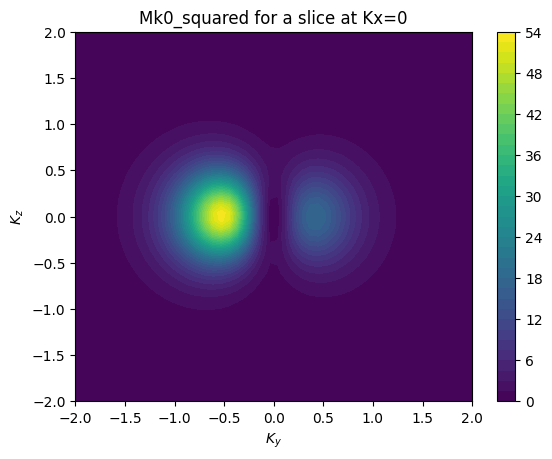

In [120]:

#Field parameters
Nc = 3 #Field revolutions in envelope
eps = 1 #(-1,0,1), Polarization of light
phi = np.pi /2 #Phase difference between envelope and field
#all values in au
wl = 0.057 #800nm wavelength
I = 0.001 #I=10^14 w/cm^2  
E0 = -0.500 #13.6 eV
res = 1000

M1 = M(Nc,eps,phi,wl,I,E0,res,envelope=saw_envelope_decay)

#Trial calculation for k along the z-axis

#kxs = np.linspace(-2,2,num=50)
kys = np.linspace(-2,2,num=50)
kzs = np.linspace(-2,2,num=50)

a = np.empty(shape=(len(kys),len(kzs)))
for j in range(0,len(kys)):
    for k in range(0,len(kzs)):
        a[k][j]=M1.Mk0_squared([0,kys[j],kzs[k]])
        #
        #print(a[k][j])

# Simple plot
plt.contourf(kys, kzs, a,50)
plt.xlabel(r'$K_y$')
plt.ylabel(r'$K_z$')
plt.colorbar()
plt.title('Mk0_squared for a slice at Kx=0')
base_filename = '250515_Msquared_plot'
i = 0
while os.path.exists(os.path.join(save_dir, f'{base_filename}_{i}.png')):
    i += 1

# Save figure with the next available index

plt.savefig(os.path.join(save_dir, f'{base_filename}_{i}.png'))



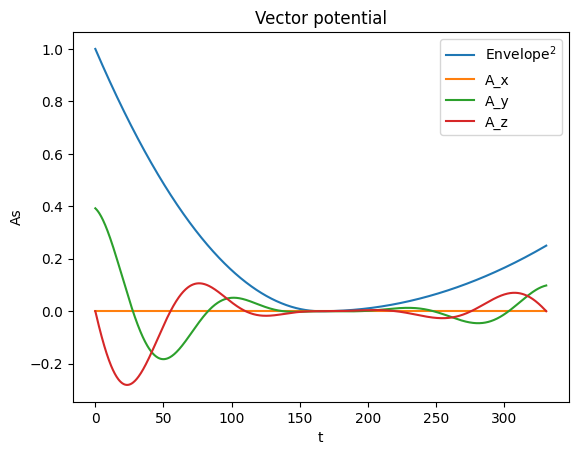

In [121]:
M1.plotAs()

## compare A and slice of k

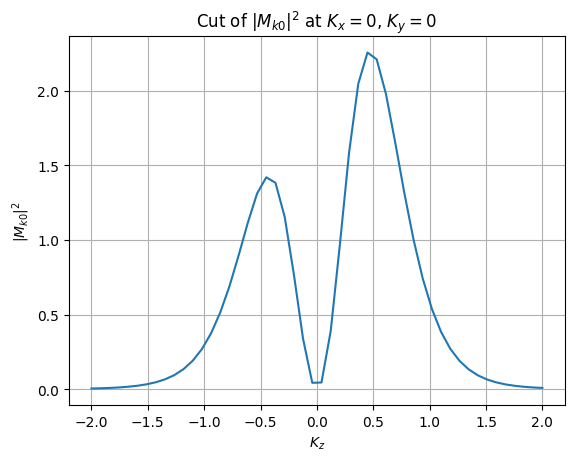

In [122]:
# Define kz values
kzs = np.linspace(-2, 2, num=50)

# Initialize an array to store results
Mk0_squared_values = []

# Calculate M1.Mk0_squared for kx = 0, ky = 0, and varying kz
for kz in kzs:
    Mk0_squared_values.append(M1.Mk0_squared([0, 0, kz]))

# Plot the results
#plt.yscale('log')
plt.plot(kzs, Mk0_squared_values)
plt.xlabel(r'$K_z$')
plt.ylabel(r'$|M_{k0}|^2$')
plt.title(r'Cut of $|M_{k0}|^2$ at $K_x = 0$, $K_y = 0$')
plt.grid()
plt.show()

In [123]:
As = M1.get_As()

Text(0, 0.5, 'amplitude')

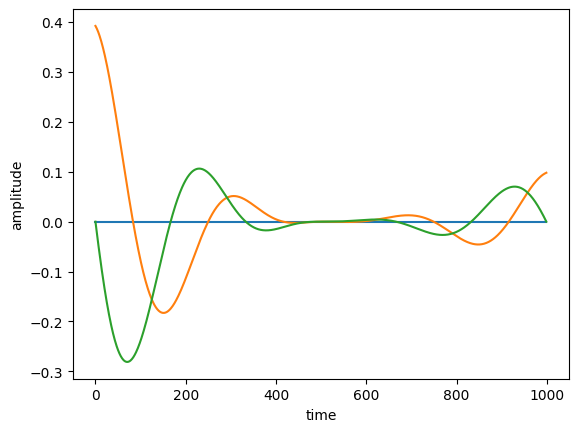

In [124]:
plt.plot(As[0,:])
plt.plot(As[1,:])
plt.plot(As[2,:])
plt.xlabel("time")
plt.ylabel("amplitude")

Text(0.5, 0, 'time')

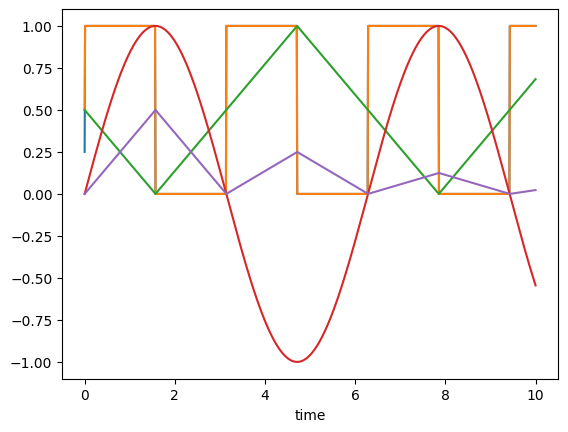

In [125]:
def saw_envelope_decay(time):
    # Normalize time to optical cycles
    cycles = (time + np.pi) / (np.pi)
    
    # Integer cycle number
    n = np.floor(cycles)
    
    # Fractional position within the current cycle
    frac = cycles - n
    
    # Sawtooth shape in [0, 1] within each cycle
    shape = 1 - np.abs(2 * (frac - 0.5))
    
    # Decaying amplitude factor: 1, 1/2, 1/4, ...
    decay = 1 / (2 ** n)
    
    return shape * decay

times_test = np.linspace(0,10,1000)
plt.plot(times_test,square_envelope(times_test)**2)
plt.plot(times_test,square_envelope(times_test))
plt.plot(times_test,saw_envelope(times_test))
plt.plot(times_test,sin_envelope(times_test))
plt.plot(times_test,saw_envelope_decay(times_test))
plt.xlabel("time")